# **GEANT4 Particle Identification**

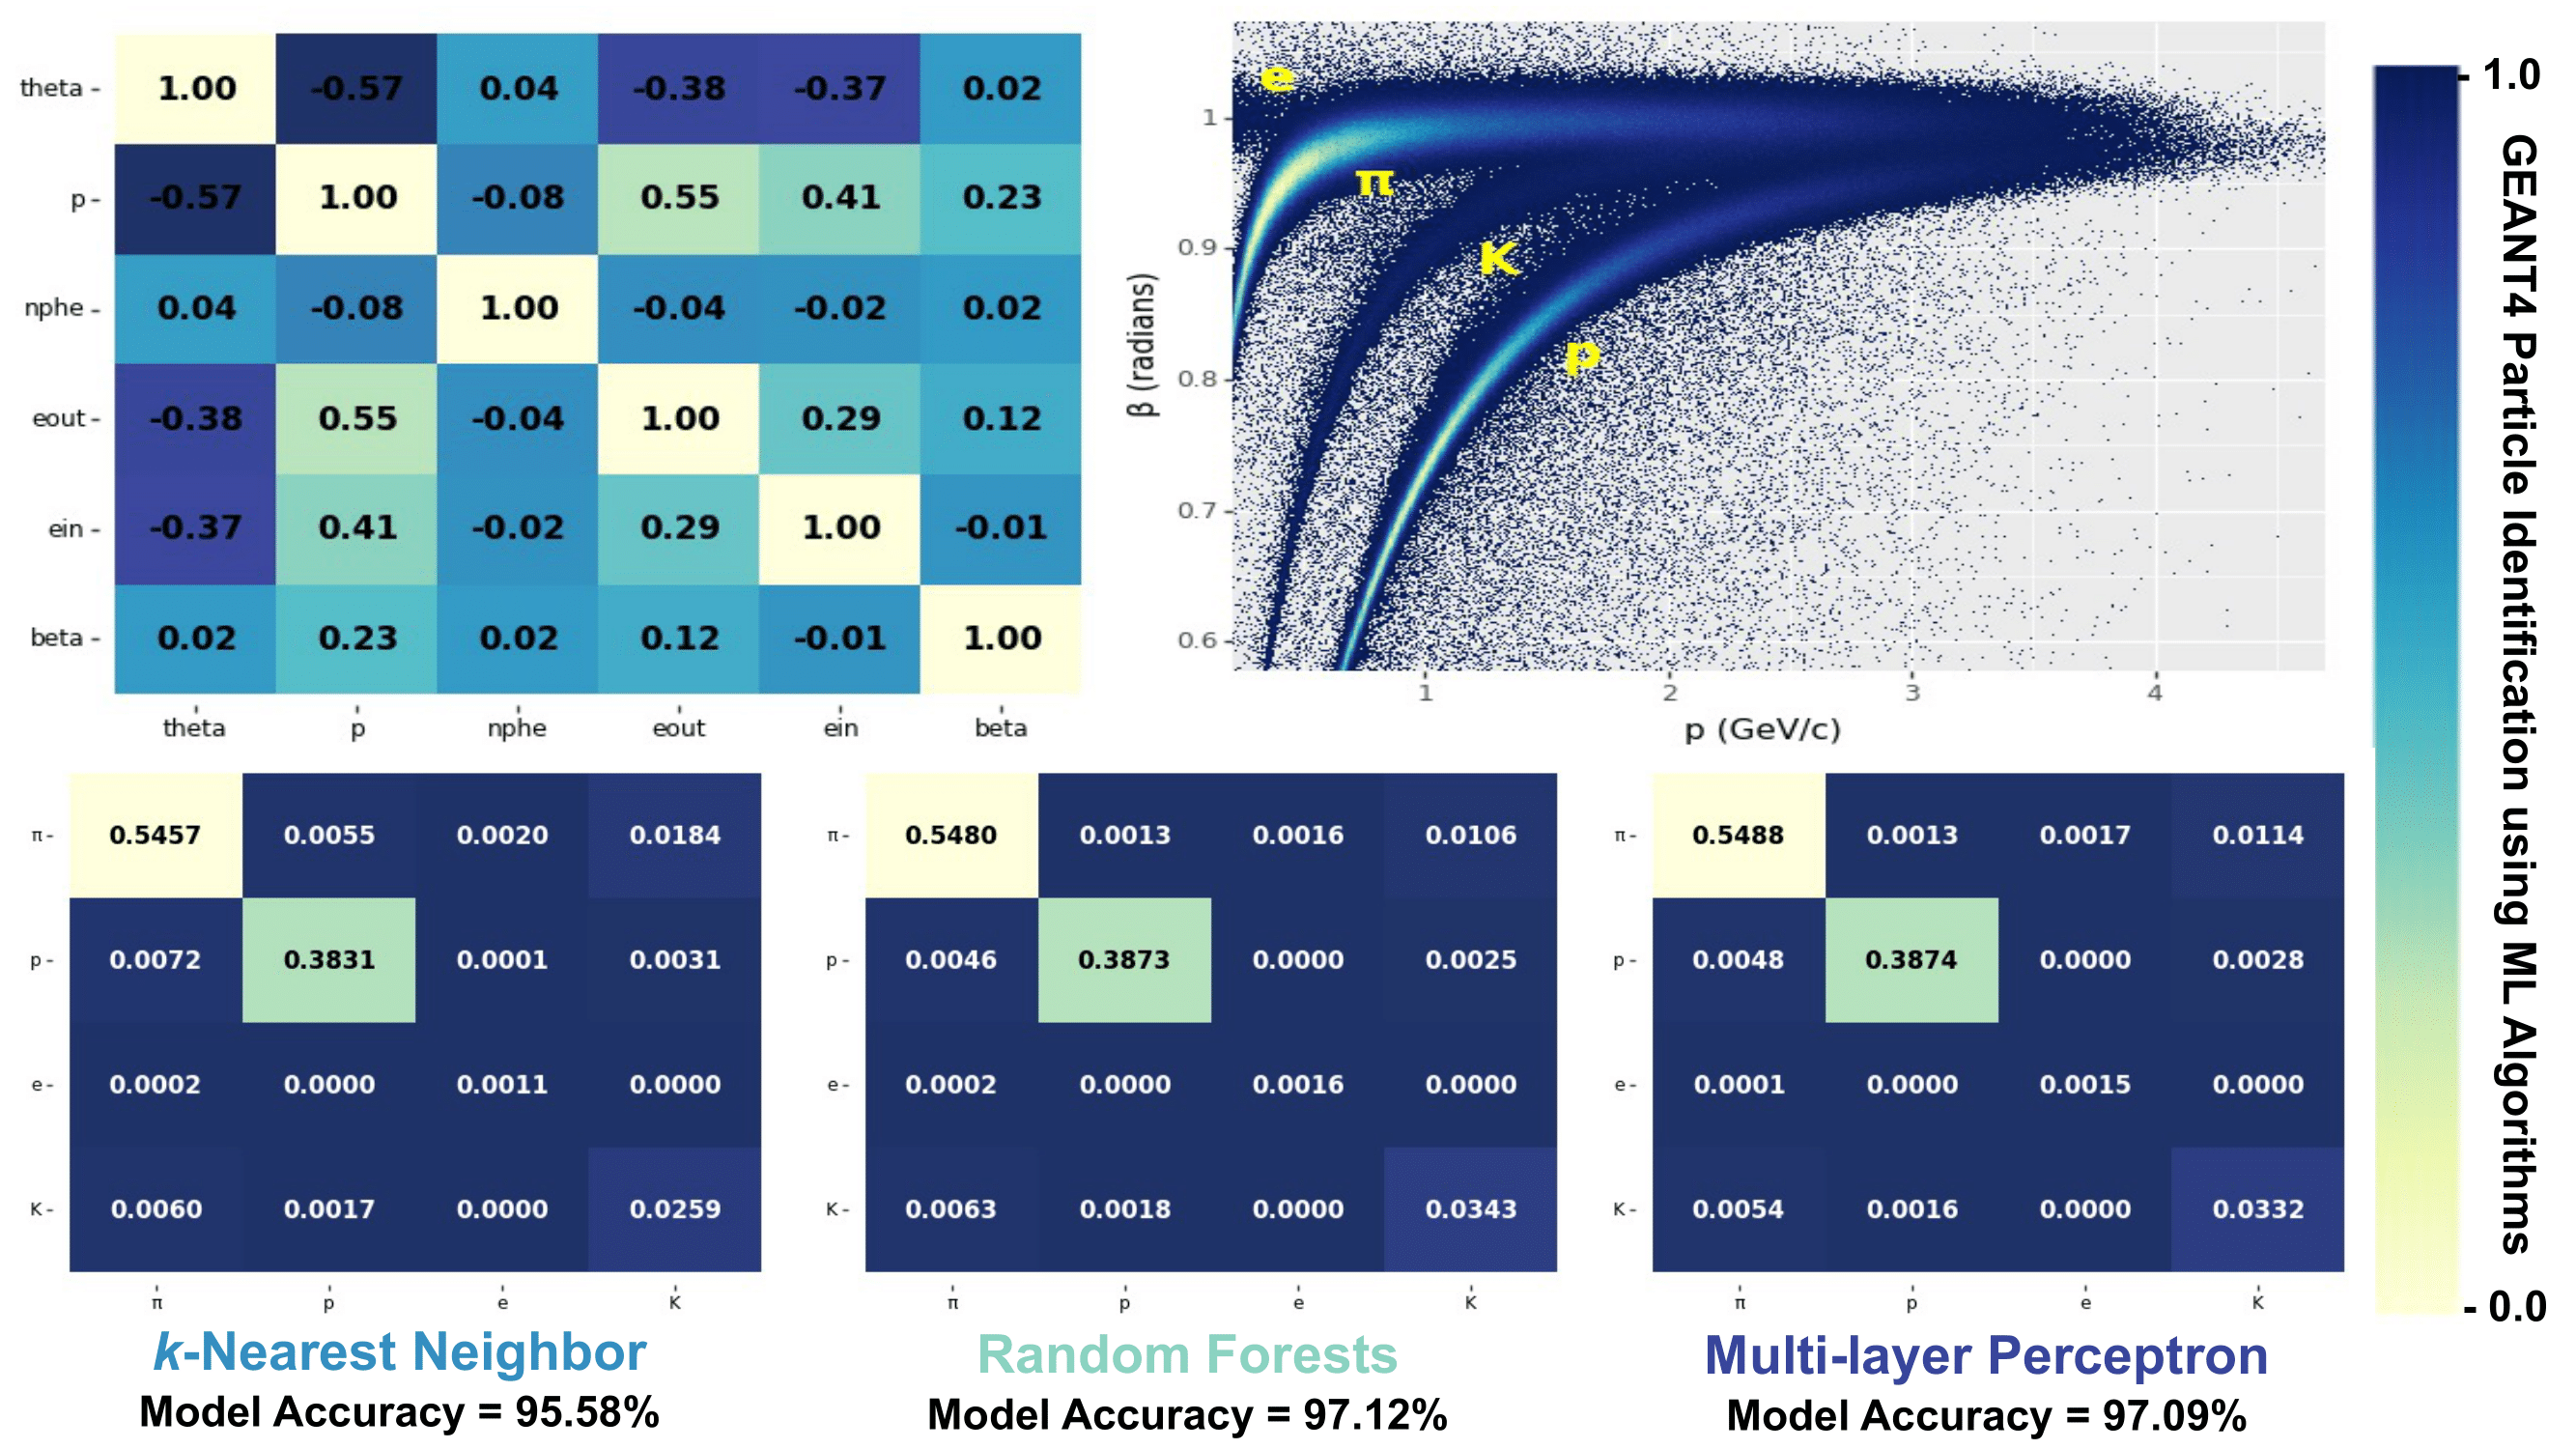

In [107]:
from google.colab import drive 
drive.mount('/content/gdrive')
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from plotnine import *
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Background

### GEANT4
GEANT4 (Geometry and Tracking) is a platform for the simulation of the passage of particles through matter using Monte Carlo methods. \\
More information: https://en.wikipedia.org/wiki/Geant4

### The Standard Model
The Standard Model of particle physics is the theory describing three of the four known fundamental forces (the electromagnetic, weak, and strong interactions, while omitting gravity) in the universe, as well as classifying all known elementary particles. \\
More information: https://en.wikipedia.org/wiki/Standard_Model

#### Quarks
A quark is a type of elementary particle and a fundamental constituent of matter. There are size types, known as flavors, of quarks: up, down, charm, strange, top, and bottom. Quarks combine to form composite particles called hadrons, the most stable of which are protons and neutrons, and components of atomic nuclei. \\
More information: https://en.wikipedia.org/wiki/Quark

#### Hadrons
A hadron is a composite subatomic particle made of two or more quarks held together by strong interaction. Hadrons are categorized into two broad families: Baryons, made of an odd number of quarks (usually three quarks) and mesons, made of an even number of quarks (usually two quarks: one quark and one antiquark). Protons and neutrons are examples of baryons whereas pions and kaons are example of mesons. \\
More information: https://en.wikipedia.org/wiki/Hadron

#### Leptons
A lepton is an elementary particle of half-integer spin (spin 1/2) that does not undergo strong interactions. There are six types of leptons: electon, electron neutrino, muon, muon neutrino, tau, and tau neutrino. For each lepton there is a corresponding antimatter antilepton. For the electron it is the antielectron, known as the positron. 
More information: https://en.wikipedia.org/wiki/Lepton

### Inelastic Scattering
In particle physics, inelastic scattering is a fundamental scattering process in which the kinetic energy of an incident particle is not conserved. Deep inelastic scattering is the name given to a process used to probe the inside of hadrons. In this case it would be to probe the inside structure of protons. During the process, the proton can break up into its constituent quarks which then form a hadronic jet. The angles $\beta$ and $\theta$ gives us information about the nature of the process. \\
More information: https://en.wikipedia.org/wiki/Inelastic_scattering

## Preparing the Dataset
The following dataset is from a simplified GEANT4 based simulation of electron-proton inelastic scattering measured by a particle detector system. 

In [ ]:
data = pd.read_csv('gdrive/My Drive/Datasets/pid-5M.csv')
# we will be using 70% of the dataset to create the train dataset and 30% for the test dataset
train = data.iloc[0:int(len(data)*0.7),:]
test = data.iloc[int(len(data)*0.7):,:]

train['id'] = train['id'].map({-11:'positron', 211:'pion', 321:'kaon', 2212:'proton'}).astype(str)
test['id'] = test['id'].map({-11:'positron', 211:'pion', 321:'kaon', 2212:'proton'}).astype(str)

train['id'] = train['id'].map({'positron':0, 'pion':1, 'kaon':2, 'proton':3}).astype(int)
test['id'] = test['id'].map({'positron':0, 'pion':1, 'kaon':2, 'proton':3}).astype(int)

In [4]:
Y_train = np.array(train['id']) # the labels for the train dataset
X_train = np.array(train.drop('id', axis=1)) # the targets for the train dataset

Y_test = np.array(test['id']) # the labels for the test dataset
X_test = np.array(test.drop('id', axis=1)) # the targets for the test dataset

In [27]:
def one_hot(x, k, dtype=np.float32):
  # Create a one-hot encoding of x of size k
  return np.array(x[:, None] == np.arange(k), dtype)

y_train = one_hot(Y_train, 4)
y_test = one_hot(Y_test, 4)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## Exploring the Dataset

There are a total of 7 columns. The ```id``` column identifies the particle (e.g., positron (-11), pion (211), kaon (321) and proton (2212)). The ```p``` column is momentum in GeV/c. The ```theta``` and ```beta``` columns are angles in radians. The ```nphe``` column is the number of photoelectrons. The ```ein``` column is the inner energy (GeV). The ```eout``` column is the outer energy (GeV).

In [63]:
positron = train[train['id']==0]['id'].value_counts()
print(positron)
pion = train[train['id']==1]['id'].value_counts()
kaon = train[train['id']==2]['id'].value_counts()
proton = train[train['id']==3]['id'].value_counts()

df = pd.DataFrame([positron, pion, kaon, proton])
print(df)

Series([], Name: id, dtype: int64)
Empty DataFrame
Columns: []
Index: [id, id, id, id]


In [17]:
# descriptive statistics for each column
data.drop(['id'], axis=1).describe()

,p,theta,beta,nphe,ein,eout
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.230053e+00,4.889321e-01,8.995796e-01,3.575243e+00,5.635883e-02,7.033195e-02
std,7.414895e-01,2.942161e-01,1.132321e-01,1.779236e+01,7.882675e-02,1.020604e-01
min,2.101170e-01,9.222140e-02,5.500010e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.657510e-01,2.817420e-01,8.378760e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.066150e+00,4.048670e-01,9.461940e-01,0.000000e+00,3.442440e-02,4.417490e-02
75%,1.649650e+00,6.117800e-01,9.855910e-01,0.000000e+00,6.834520e-02,9.365990e-02
max,5.286950e+00,2.219270e+00,1.499590e+00,3.490000e+02,8.993820e-01,1.097410e+00


In [18]:
# train data set
print(train.shape)
train.head()

(3500000, 7)


,id,p,theta,beta,nphe,ein,eout
0,1,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,1,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,3,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,1,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,3,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [19]:
# test data set
print(test.shape)
test.head()

(1500000, 7)


,id,p,theta,beta,nphe,ein,eout
3500000,1,0.643931,0.549808,0.985108,0,0.000000,0.000000
3500001,3,2.757920,0.230921,0.954517,0,0.284779,0.093339
3500002,1,0.675975,0.415607,0.975645,0,0.112337,0.000000
3500003,3,1.653930,0.474822,0.882879,0,0.048203,0.058778
3500004,1,0.929122,0.130140,0.984750,0,0.203067,0.000000


## Correlation Matrix

Below we are investigating the correlation matrix of the features. 

In [20]:
# compute pairwise correlation of columns, excluding NA/null values
cor_data = (data.drop(['id'], axis=1)
              .corr().stack()
              .reset_index()    
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format) 
cor_data.head()

,variable,variable2,correlation,correlation_label
0,p,p,1.000000,1.00
1,p,theta,-0.568578,-0.57
2,p,beta,0.226958,0.23
3,p,nphe,-0.080424,-0.08
4,p,ein,0.413338,0.41


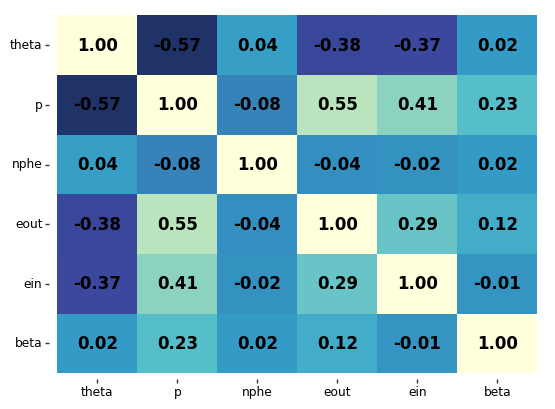

<ggplot: (8778071012725)>

In [21]:
cor_data['variable'] = pd.Categorical(cor_data['variable'], categories=["theta", "p", "nphe", "eout", "ein", "beta"], ordered=True)

corr_plot = ggplot(data=cor_data) \
          + geom_tile(mapping=aes(x="variable", y="variable2", fill="correlation"), alpha=0.9, show_legend=False) \
          + geom_text(aes(x="variable", y="variable2", label='correlation_label'), size=12, color='black', fontweight='bold') \
          + scale_fill_cmap("YlGnBu_") \
          + labs(x='', y='', fill='') \
          + theme(text=element_text(color='black'), panel_grid_major=element_blank(), panel_grid_minor=element_blank(), panel_background=element_blank())
corr_plot

In [ ]:
cor_data['variable'] = pd.Categorical(cor_data['variable'], categories=["theta", "p", "nphe", "eout", "ein", "beta"], ordered=True)


## Beta vs. Momentum

The Beta vs. Momentum plot shows the relationship between the $\beta$ measured by the ToF system and the momentum, p obtained from TPC. The visible bands are from $e^+$ (positron), $\pi^+$ (pion), $K^-$ (kaon), and p (proton).

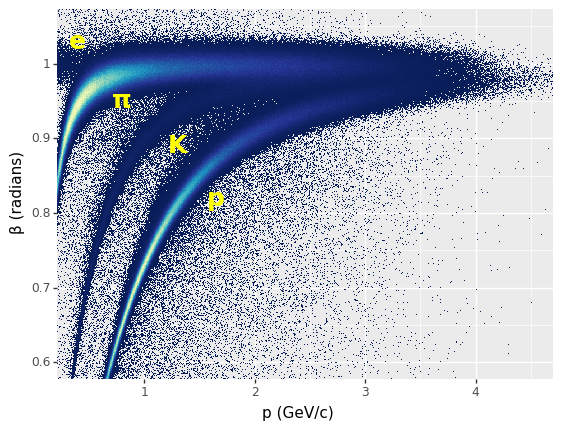

<ggplot: (8778068093377)>

In [23]:
density_plot = ggplot(data=data) \
             + geom_bin2d(aes(x='p', y='beta'), bins=1000, show_legend=False) \
             + scale_fill_continuous("YlGnBu_r") \
             + labs(x='p (GeV/c)', y='β (radians)', color='black') \
             + coord_cartesian(ylim=(0.6, 1.05), xlim=(0.42, 4.5)) \
             + annotate("text", x = 0.4, y = 1.03, label = "e", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 0.8, y = 0.95, label = "π", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 1.3, y = 0.89, label = "K", color='yellow', size = 18, fontweight="bold") \
             + annotate("text", x = 1.65, y = 0.82, label = "p", color='yellow', size = 18, fontweight="bold") 
density_plot

## Sizing Down the Data

In [ ]:
sample_Y_train = np.delete(Y_train, np.s_[0:3200000:1], 0)
print(sample_Y_train.shape)
sample_X_train = np.delete(X_train, np.s_[0:3200000:1], 0)
print(sample_X_train.shape)

sample_Y_test = np.delete(Y_test, np.s_[0:1410000:1], 0)
print(sample_Y_test.shape)
sample_X_test = np.delete(X_test, np.s_[0:1410000:1], 0)
print(sample_X_test.shape)

## $k$-Nearest Neighbors ($k$-NN)

The $k$-nearest neighbors algorithm (k-NN) is a non-parametric classification method. For a classification problem, the input consists of the $k$ closest training examples in a data set. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$ nearest neighbors. If $k=1$, then the object is simply assigned to the class of that single nearest neighbor.

More information: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm


In [137]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(sample_X_train, sample_Y_train)
y_pred = knn.predict(sample_X_test)

### $k$-Nearest Neighbors ($k$-NN) Confusion Matrix

In [138]:
knn_results = confusion_matrix(sample_Y_test, y_pred, normalize='all')
confusion = knn_results.flatten()

labels = {0: 'e', 1: 'π', 2: 'K', 3: "p"}
arr = [[x, y] for x in range(0, 4) for y in range(0,4)]
list1, list2 = zip(*arr)
Predicted_Label = [labels[x] for x in list1]
True_Label = [labels[x] for x in list2]

knn_df = pd.DataFrame(data={'Predicted Label':Predicted_Label, 'True Label':True_Label, 'Confusion':confusion})
knn_df['Confusion_Label'] = knn_df['Confusion'].map('{:.4f}'.format)

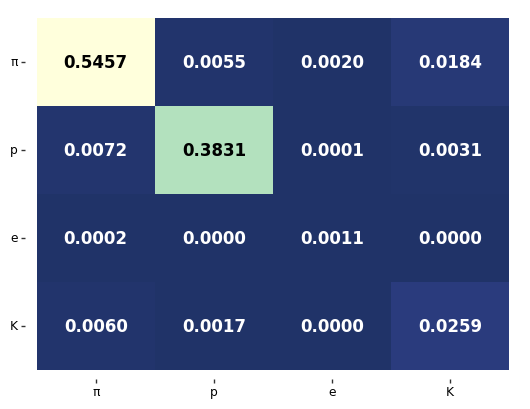

<ggplot: (8753004632669)>

In [139]:
knn_df['Predicted Label'] = pd.Categorical(knn_df['Predicted Label'], categories=['π', 'p', 'e', 'K'], ordered=True)

cm_knn_plot = ggplot(data=knn_df) \
            + geom_tile(mapping=aes(x="Predicted Label", y="True Label", fill="Confusion"), alpha=0.9, show_legend=False) \
            + geom_text(aes(x="Predicted Label", y="True Label", label="Confusion_Label"), size=12, color = np.where(confusion < 0.2, 'white', 'black'), fontweight='bold') \
            + scale_fill_cmap("YlGnBu_r") \
            + labs(x='', y='', fill='') \
            + theme(text=element_text(color='black'), panel_grid_major=element_blank(), panel_grid_minor=element_blank(), panel_background=element_blank())
cm_knn_plot

In [83]:
knn_accuracy = metrics.accuracy_score(sample_Y_test, y_pred)*100
print('k-NN Accuracy:', knn_accuracy, '%')

k-NN Accuracy: 95.5788888888889 %


## Random Forests

Random forests or random decision forests are an ensemble learning method for tasks that operate by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. Random forests correct for decision trees' habit of overfitting to their training set.

More information: https://en.wikipedia.org/wiki/Random_forest

In [131]:
randForests = RandomForestClassifier()
randForests.fit(sample_X_train, sample_Y_train)
y_pred = randForests.predict(sample_X_test)

### Random Forests Confusion Matrix

In [134]:
randForests_results = confusion_matrix(sample_Y_test, y_pred, normalize='all')
confusion = randForests_results.flatten()

randForests_df = pd.DataFrame(data={'Predicted Label':Predicted_Label, 'True Label':True_Label, 'Confusion':confusion})
randForests_df['Confusion_Label'] = randForests_df['Confusion'].map('{:.4f}'.format) 

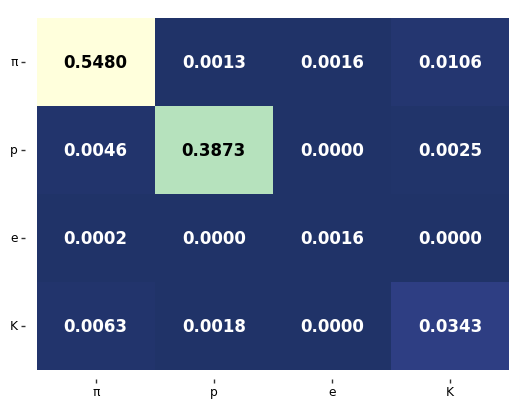

<ggplot: (8753004721545)>

In [136]:
randForests_df['Predicted Label'] = pd.Categorical(randForests_df['Predicted Label'], categories=['π', 'p', 'e', 'K'], ordered=True)

cm_randForests_plot = ggplot(data=randForests_df) \
                    + geom_tile(mapping=aes(x="Predicted Label", y="True Label", fill="Confusion"), alpha=0.9, show_legend=False) \
                    + geom_text(aes(x="Predicted Label", y="True Label", label="Confusion_Label"), size=12, color = np.where(confusion < 0.2, 'white', 'black'), fontweight='bold') \
                    + scale_fill_cmap("YlGnBu_r") \
                    + labs(x='', y='', fill='') \
                    + theme(text=element_text(color='black'), panel_grid_major=element_blank(), panel_grid_minor=element_blank(), panel_background=element_blank())
cm_randForests_plot

In [87]:
randForests_accuracy = metrics.accuracy_score(sample_Y_test, y_pred)*100
print('Random Forests Accuracy:', randForests_accuracy, '%')

Random Forests Accuracy: 97.11666666666666 %


## Deep Neural Multilayer Perceptron (MLP)

In [108]:
sc = StandardScaler()
X_trainscaled=sc.fit_transform(sample_X_train)
X_testscaled=sc.transform(sample_X_test)
MLP = MLPClassifier(hidden_layer_sizes=(6, 25, 25, 4), activation="relu", random_state=1).fit(X_trainscaled, sample_Y_train)
y_pred = MLP.predict(X_testscaled)

### Deep Neural Multilayer Perceptron (MLP) Confusion Matrix

A multilayer perceptron (MLP) is a class of feedforward artifical neural network (ANN). An MLP consists of at least three layers of nodes, an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. The ReLU activation function was used in this project. \\
More information: https://en.wikipedia.org/wiki/Multilayer_perceptron

In [ ]:
MLP_results = confusion_matrix(sample_Y_test, y_pred, normalize='all')
confusion = MLP_results.flatten()

MLP_df = pd.DataFrame(data={'Predicted Label':Predicted_Label, 'True Label':True_Label, 'Confusion':confusion})
MLP_df['Confusion_Label'] = MLP_df['Confusion'].map('{:.4f}'.format) 

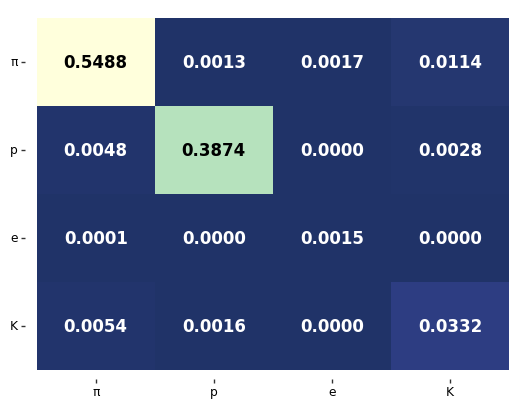

<ggplot: (8753004813521)>

In [128]:
MLP_df['Predicted Label'] = pd.Categorical(MLP_df['Predicted Label'], categories=['π', 'p', 'e', 'K'], ordered=True)

cm_MLP_plot = ggplot(data=MLP_df) \
                    + geom_tile(mapping=aes(x="Predicted Label", y="True Label", fill="Confusion"), alpha=0.9, show_legend=False) \
                    + geom_text(aes(x="Predicted Label", y="True Label", label="Confusion_Label"), size=12, color = np.where(confusion < 0.2, "white", "black"), fontweight='bold') \
                    + scale_fill_cmap("YlGnBu_r") \
                    + labs(x='', y='', fill='') \
                    + theme(text=element_text(color='black'), panel_grid_major=element_blank(), panel_grid_minor=element_blank(), panel_background=element_blank())
cm_MLP_plot

In [119]:
MLP_accuracy = metrics.accuracy_score(sample_Y_test, y_pred)*100
print('Random Forests Accuracy:', MLP_accuracy, '%')

Random Forests Accuracy: 97.09 %
